## 生成仿真数据

In [14]:
import numpy as np
import pandas as pd
import time

# =============================================================================
# Generate User-Item Matrix
# =============================================================================
n_u = 1000  # user number
n_v = 100   # item number
n_r = 5 # average number of ratings per user
n_factors = 5  # number of latent factors
V = 100 # vocabulary size
beta = 0.01
kappa = 1.0
n_w = 30 # avg length of review
np.random.seed(0)

bias_user = np.zeros(n_u)
U_matrix = np.zeros((n_u,n_factors))
# generate bias and latent fators for users
for i in range(n_u):
    bias_user[i] = np.random.normal()
    mean = np.zeros(n_factors)
    cov = np.eye(n_factors)
    U_matrix[i] = np.abs(np.random.multivariate_normal(mean, cov))

bias_item = np.zeros(n_v)
V_matrix = np.zeros((n_v,n_factors))
# generate bias and latent factors for items
for j in range(n_v):
    bias_item[j] = np.random.normal()
    mean = np.zeros(n_factors)
    cov = np.eye(n_factors)
    V_matrix[j] = np.random.multivariate_normal(mean, cov)

# generate word distributions for topics (latent factors)
phi = np.zeros((n_factors*2,V))
for k in range(n_factors*2):
    phi[k] = np.random.dirichlet([beta]*V)


data = []
data_theta = []
# generate ratings and reviews given users and items
for i in range(n_u):
    n_ur = np.random.poisson(n_r)
    select_items = np.random.choice(np.arange(n_v), n_ur)    
    for j in select_items:
        residual = np.random.normal(scale=1.0)
        score_ij = bias_user[i] + bias_item[j] + U_matrix[i].dot(V_matrix[j]) + residual
        theta_pos = np.exp(kappa * U_matrix[i] * V_matrix[j])
        theta_neg = np.exp(-1 * kappa * U_matrix[i] * V_matrix[j])
        theta = np.concatenate((theta_pos,theta_neg))
        theta /= np.sum(theta)
        doc = []
        for n in range(n_w):
            k = np.random.choice(np.arange(n_factors*2),p=theta)
            w = np.random.choice(np.arange(V),p=phi[k])
            doc.append(w)
        data.append([i,j,score_ij,doc])
        data_theta.append(theta)
df = pd.DataFrame(data,columns = ['user','item','rating','review'])
vocab = dict(enumerate([str(w) for w in list(range(V))]))
#df.to_csv('rating_matrix.csv')

# validation set
val_data = []
errors = 0
for i in range(n_u):
    j = np.random.choice(np.arange(n_v))
    residual = np.random.normal(scale=1.0)
    errors += residual**2
    score_ij = bias_user[i] + bias_item[j] + U_matrix[i].dot(V_matrix[j]) + residual
    val_data.append([i, j, score_ij])
val_df = pd.DataFrame(val_data, columns=['user', 'item', 'rating'])

print(val_df['rating'].var())
print(df['rating'].mean())


7.53212856421111
-0.10027677433391241


In [15]:
ranges = []
for theta_d in data_theta:
    ranges.append(np.max(theta_d)-np.min(theta_d))
print(np.mean(ranges))

0.3344015712163282


In [3]:
df.shape[0], val_df.shape[0]

(5070, 1000)

## 模型学习

In [51]:
# =============================================================================
# Offline Estimation based on JSTRMR
# =============================================================================

from dataset import Dataset
trainset = Dataset(corpus=df, vocab=vocab)

In [52]:
from JSTRMR import JSTRMR
model = JSTRMR(trainset, K=n_factors, weight=2.0)

In [23]:
model.Inference()

Processing epoch 0, loss of reviews = 364360.64077673474, loss of ratings = 12320.80479846352
Processing epoch 1, loss of reviews = 362140.0022684069, loss of ratings = 12319.183832716568
Processing epoch 2, loss of reviews = 354046.60848040343, loss of ratings = 12316.063081496639
Processing epoch 3, loss of reviews = 336794.7403252036, loss of ratings = 12312.599655999842
Processing epoch 4, loss of reviews = 314198.25899891363, loss of ratings = 12301.316082994566
Processing epoch 5, loss of reviews = 294107.30514563265, loss of ratings = 12296.868874203035
Processing epoch 6, loss of reviews = 277894.49062267493, loss of ratings = 12293.138346016964
Processing epoch 7, loss of reviews = 266003.7890963928, loss of ratings = 12285.716747256885
Processing epoch 8, loss of reviews = 257683.1185326746, loss of ratings = 12279.2142386982
Processing epoch 9, loss of reviews = 251943.99682367087, loss of ratings = 12274.177556597671
Processing epoch 10, loss of reviews = 247774.17065611377

KeyboardInterrupt: 

In [8]:
model.mu[0],model.mu[1],model.sigma[0],model.sigma[1]

(2.1197157517488874,
 -2.2192827475725445,
 1.6181853511896236,
 1.7583023199629984)

In [3]:
import gzip
import _pickle as cPickle

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
        
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [28]:
# save model for further use    
save_zipped_pickle(model, './models/kappa3/JSTRMR_weight2.0.p')

In [4]:
import gzip
import _pickle as cPickle

# load existing model
with gzip.open('./models/kappa3/JSTRMR/JSTRMR_weight5.0.p', 'rb') as f:
    model = cPickle.load(f)

c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
c:\users\liang\appdata\local\programs\python\python36\lib\site-packages\paramiko\transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend


In [10]:
for weight in [7.0, 15.0, 20.0]:
    model = JSTRMR(trainset, K=n_factors, weight=weight)
    model.Inference(threshold=0.001)
    print("******** weight = ",weight,"mu and sigma: ",model.mu[0],model.sigma[0],model.mu[1],model.sigma[1],"********")
    save_zipped_pickle(model, './models/kappa0.5/JSTRMR_weight' + str(weight) + '.p')

Processing epoch 0, loss of reviews = 364075.17536369123, loss of ratings = 11534.514909865422
Processing epoch 1, loss of reviews = 363712.75358186086, loss of ratings = 11278.994544421006
******** weight =  7.0 mu and sigma:  1.8105555695549438 1.9242346630993588 -1.9605304497196772 2.0759176403204904 ********
Processing epoch 0, loss of reviews = 363893.9958655309, loss of ratings = 11102.792284135423
Processing epoch 1, loss of reviews = 363566.2374405932, loss of ratings = 10847.066045714346
******** weight =  15.0 mu and sigma:  1.8538088868816978 1.890621955077369 -2.008652829439216 2.022546776018185 ********
Processing epoch 0, loss of reviews = 363822.0169222428, loss of ratings = 10968.16634952913
Processing epoch 1, loss of reviews = 363515.15203364147, loss of ratings = 10721.853548450576
******** weight =  20.0 mu and sigma:  1.882430414550679 1.87391955027458 -2.013819758955088 2.0052206868707034 ********


In [9]:
kappa

0.5

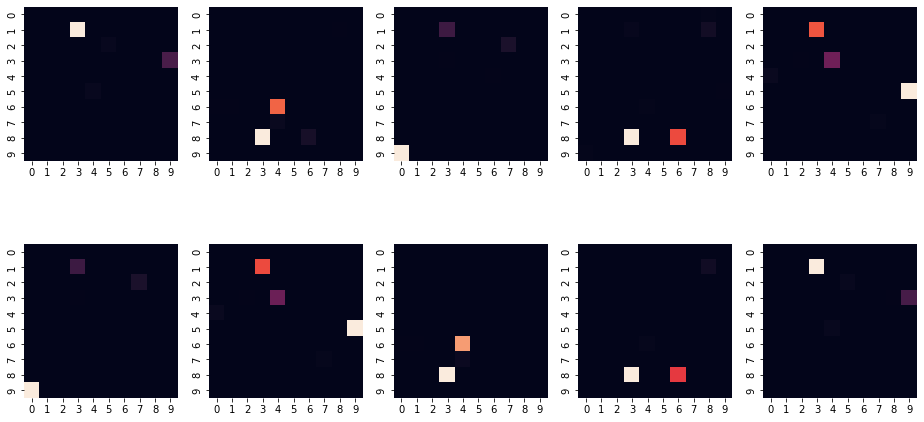

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(16,8))
for factor in range(n_factors):
    plt.subplot(2,n_factors,factor+1)
    sns.heatmap(data=model.phi[factor,0].reshape((10,10)),square=True,cbar=False)
    plt.subplot(2,n_factors,factor+1+n_factors)
    sns.heatmap(data=phi[factor].reshape((10,10)),square=True,cbar=False)

# 显示图形
plt.show()

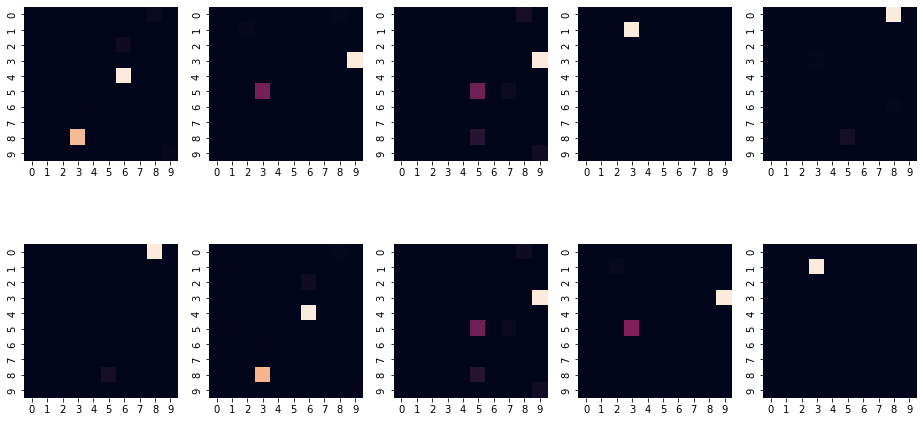

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(figsize=(16,8))
for factor in range(n_factors):
    plt.subplot(2,n_factors,factor+1)
    sns.heatmap(data=model.phi[factor,1].reshape((10,10)),square=True,cbar=False)
    plt.subplot(2,n_factors,factor+1+n_factors)
    sns.heatmap(data=phi[factor+n_factors].reshape((10,10)),square=True,cbar=False)

# 显示图形
plt.show()

## UCL search

In [16]:
import gzip
import _pickle as cPickle

# load existing model
with gzip.open('./models/kappa1/JSTRMR/JSTRMR_weight3.0.p', 'rb') as f:
    model = cPickle.load(f)

In [17]:
kappa

1.0

In [89]:
# =============================================================================
# Generate In-Control Data and Search UCL
# =============================================================================
smoothing = 0.05 # smoothing parameter for EWMA
model.rho = (1-smoothing)/smoothing
item_id = 0 # select a specific item
m = 100 # reference sample size
n = 5 # test sample size
RL_trys = 1000 # number of trys for run lengths
UCL_l = 0.01015625 # lower search bound of UCL
UCL_u = 0.010234375 # upper search bound of UCL 
UCL_0 = (UCL_l + UCL_u)/2
ARL = 0

print("sentiment UCL search for kappa=3 and smoothing=0.05")
print('ARL={}, next search range: ({},{}), try UCL = {}'.format(ARL, UCL_l, UCL_u, UCL_0))

while abs(ARL-370) > 7:   
    RL = [] # to record each RL
    for k in range(RL_trys):
        # generate m reference samples
        ref_samples = []
        for i in range(m):
            residual = np.random.normal(scale=1.0)
            user_id = np.random.choice(np.arange(n_u))
            score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual           
            theta_pos = np.exp(kappa * U_matrix[user_id] * V_matrix[item_id])
            theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * V_matrix[item_id])
            theta = np.concatenate((theta_pos,theta_neg))
            theta /= np.sum(theta)
            doc = []
            for idx in range(n_w):
                k = np.random.choice(np.arange(n_factors*2),p=theta)
                w = np.random.choice(np.arange(V),p=phi[k])
                doc.append(w)
            ref_samples.append([user_id,item_id,score,doc])
        df_ref = pd.DataFrame(ref_samples, columns = ['user','item','rating','review'])
        # get avg pi and theta in reference samples
        pi, theta = model.online_Inference(new_corpus=df_ref,epochs=20)
        ref_pi = np.mean(pi,axis=0)
        ref_theta = np.mean(theta,axis=0)
        
        # RL computing        
        cur_RL = 5000
        for j in range(1,5001):
            # generate n test samples
            test_samples = []
            for i in range(n):
                residual = np.random.normal(scale=1.0)
                user_id = np.random.choice(np.arange(n_u))
                score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
                theta_pos = np.exp(kappa * U_matrix[user_id] * (V_matrix[item_id]))
                theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * (V_matrix[item_id]))
                theta = np.concatenate((theta_pos,theta_neg))            
                theta /= np.sum(theta)
                doc = []
                for idx in range(n_w):
                    k = np.random.choice(np.arange(n_factors*2),p=theta)
                    w = np.random.choice(np.arange(V),p=phi[k])
                    doc.append(w)
                test_samples.append([user_id,item_id,score,doc])
            df_test = pd.DataFrame(test_samples, columns = ['user','item','rating','review'])
            if j == 1:
                pi_j, theta_j = model.online_sequential_Inference(ref_pi, ref_theta, df_test, epochs=5)
            else:
                pi_j, theta_j = model.online_sequential_Inference(pi_j, theta_j, df_test, epochs=5)
            
            # compute sentiment statistic
            Q_j_senti = np.sum(pi_j * np.log(pi_j/ref_pi))  
            if Q_j_senti > UCL_0:
                cur_RL = j
                break
            '''
            # compute topic statistic
            Q_j_topic = 0
            for s in range(model.S):
                Q_j_topic += pi_j[s] * np.sum(theta_j[s] * np.log(theta_j[s]/ref_theta[s]))
            if Q_j_topic > UCL_0:
                cur_RL = j
                break
            '''

        RL.append(cur_RL)
        print(len(RL),np.mean(RL),np.std(RL)/np.sqrt(len(RL)))

            
    ARL = np.mean(RL)   
    if ARL < 370:
        UCL_l = UCL_0
        UCL_0 = (UCL_l+UCL_u)/2
    else:
        UCL_u = UCL_0
        UCL_0 = (UCL_l+UCL_u)/2
    print('ARL={}, ARL_std={}, next search range: ({},{}), try UCL = {}'.format(ARL, np.std(RL)/np.sqrt(len(RL)), UCL_l, UCL_u, UCL_0))
    

print(np.mean(RL),np.std(RL)/np.sqrt(len(RL)))

sentiment UCL search for kappa=3 and smoothing=0.05
ARL=0, next search range: (0.01015625,0.010234375), try UCL = 0.010195312500000001
1 1292.0 0.0
2 661.5 445.8308255381182
3 565.3333333333334 307.4173180017798
4 563.25 230.57004765363604
5 511.6 190.15311725028332
6 454.8333333333333 166.71906120888028
7 460.85714285714283 143.01083569214057
8 423.75 129.859389100288
9 391.3333333333333 119.40810816814867
10 372.2 108.98943068022696
11 352.1818181818182 100.90293332415307
12 332.0 94.49110775329308
13 310.46153846153845 89.64371393655355
14 294.57142857142856 84.63720380672777
15 277.8666666666667 80.62637377526133
16 268.4375 76.13659439362503
17 269.4117647058824 71.66420440185166
18 320.22222222222223 83.78092963256032
19 406.7894736842105 115.7553198180991
20 423.55 111.17433325637712
21 424.3809523809524 105.88342274288357
22 407.27272727272725 102.44335628620613
23 416.17391304347825 98.37524417283011
24 408.8333333333333 94.54974929946982
25 407.56 90.77633312708771
26 392.846

KeyboardInterrupt: 

In [17]:
np.mean(RL), np.std(RL)/400

(371.1910225763612, 10.040915347002562)

In [16]:
np.sqrt(len(RL))

137.20422734012243

## Phase-II monitoring

In [81]:
import gzip
import _pickle as cPickle

# load existing model
#with gzip.open('./models/model_onlyrating.p', 'rb') as f:
with gzip.open('./models/kappa10/model_united_reg0.2_lamb0.02.p', 'rb') as f:
    model = cPickle.load(f)

In [68]:
V_matrix[0]

array([-0.91946118,  0.11467003, -0.1374237 ,  1.36552692, -0.26163835])

In [18]:
kappa

1.0

In [21]:
# =============================================================================
# Risk-adjusted Monitoring of Out-of-Control Data
# =============================================================================
            
model.rho = 0.95/0.05 # smoothing parameter 0.2 for EWMA
item_id = 0 # select a specific item
m = 100 # reference sample size
n = 5 # test sample size
RL_trys = 10000 # number of trys for run lengths
UCL_senti = 0.008433 # lower search bound of UCL
UCL_topic = 0.18515 # upper search bound of UCL 
bias_item_shift = -1
factor_item_shift = np.array([0,0,0,-1,0])


print("ARL1 for kappa=1 and smoothing=0.05, bias shift -1")
RL = [] # to record each RL
for k in range(RL_trys):
    # generate m reference samples
    ref_samples = []
    for i in range(m):
        residual = np.random.normal(scale=1.0)
        user_id = np.random.choice(np.arange(n_u))
        score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
        theta_pos = np.exp(kappa * U_matrix[user_id] * V_matrix[item_id])
        theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * V_matrix[item_id])
        theta = np.concatenate((theta_pos,theta_neg))
        theta /= np.sum(theta)
        doc = []
        for idx in range(n_w):
            k = np.random.choice(np.arange(n_factors*2),p=theta)
            w = np.random.choice(np.arange(V),p=phi[k])
            doc.append(w)
        ref_samples.append([user_id,item_id,score,doc])
    df_ref = pd.DataFrame(ref_samples, columns = ['user','item','rating','review'])
    # get avg pi and theta in reference samples
    pi, theta = model.online_Inference(new_corpus=df_ref,epochs=20)
    ref_pi = np.mean(pi,axis=0)
    ref_theta = np.mean(theta,axis=0)
    
    # RL computing        
    cur_RL = 5000
    signal = None
    for j in range(1,5001):
        # generate n test samples
        test_samples = []
        for i in range(n):
            residual = np.random.normal(scale=1.0)
            user_id = np.random.choice(np.arange(n_u))
            #score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id]) + residual
            score = bias_user[user_id] + bias_item[item_id] + bias_item_shift + U_matrix[user_id].dot(V_matrix[item_id]) + residual
            #score = bias_user[user_id] + bias_item[item_id] + U_matrix[user_id].dot(V_matrix[item_id] + factor_item_shift) + residual
            theta_pos = np.exp(kappa * U_matrix[user_id] * (V_matrix[item_id]))
            theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * (V_matrix[item_id]))
            #theta_pos = np.exp(kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
            #theta_neg = np.exp(-1 * kappa * U_matrix[user_id] * (V_matrix[item_id] + factor_item_shift))
            theta = np.concatenate((theta_pos,theta_neg))            
            theta /= np.sum(theta)
            doc = []
            for idx in range(n_w):
                k = np.random.choice(np.arange(n_factors*2),p=theta)
                w = np.random.choice(np.arange(V),p=phi[k])
                doc.append(w)
            test_samples.append([user_id,item_id,score,doc])
        df_test = pd.DataFrame(test_samples, columns = ['user','item','rating','review'])
        if j == 1:
            pi_j, theta_j = model.online_sequential_Inference(ref_pi, ref_theta, df_test, epochs=5)
        else:
            pi_j, theta_j = model.online_sequential_Inference(pi_j, theta_j, df_test, epochs=5)
        
        
        # compute sentiment statistic
        Q_j_senti = np.sum(pi_j * np.log(pi_j/ref_pi))  
        if Q_j_senti > UCL_senti:
            cur_RL = j
            signal = "sentiment"
            break
        '''
        # compute topic statistic
        Q_j_topic = 0
        for s in range(model.S):
            Q_j_topic += pi_j[s] * np.sum(theta_j[s] * np.log(theta_j[s]/ref_theta[s]))
        if Q_j_topic > UCL_topic:
            cur_RL = j
            signal = "topic"
            break
        '''
        
    RL.append(cur_RL)
    #if len(RL)%200 == 0:
    print(len(RL),np.mean(RL),np.std(RL)/np.sqrt(len(RL)),signal)
    

ARL1 for kappa=1 and smoothing=0.05, bias shift -1
1 945.0 0.0 sentiment
2 1295.0 247.48737341529161 sentiment
3 2530.0 1021.7822120632601 None
4 3044.5 886.4561819402018 sentiment
5 2609.8 808.7559533011179 sentiment
6 2208.0 767.3086442596327 sentiment
7 2384.1428571428573 677.60919531419 sentiment
8 2711.125 667.1526117927405 None
9 2474.0 633.7655640088508 sentiment
10 2251.6 608.1605084186247 sentiment
11 2501.4545454545455 602.0139940115388 None
12 2709.6666666666665 586.7484830891406 None
13 2522.6923076923076 570.6276662989135 sentiment
14 2699.6428571428573 556.62881604207 None


KeyboardInterrupt: 

In [69]:
np.mean(RL),np.std(RL)/np.sqrt(len(RL))

(369.46410014171, 7.829467375682993)

In [76]:
import pandas as pd
dd = pd.DataFrame(RL,columns=['RL'])
dd.to_clipboard()